In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # plotting
import PdM_functions as pdm # custom functions created for this project that are used in several notebooks

In [3]:
# Water pump sensor data (via Kaggle datasets)
selected_fp = 'data/Pump Sensors/sensor.csv'
df_raw = pd.read_csv(selected_fp, sep = ",")
df_raw['timestamp'].head(3)

0    2018-04-01 00:00:00
1    2018-04-01 00:01:00
2    2018-04-01 00:02:00
Name: timestamp, dtype: object

In [4]:
df_raw.describe()

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,110159.500000,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,63601.049991,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,55079.750000,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,110159.500000,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,165239.250000,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,220319.000000,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


In [5]:
# Convert timestamp to datetime datatype & sort
df_raw = df_raw.drop('Unnamed: 0', axis = 1)\
  .assign(timestamp = lambda x: pd.to_datetime(x['timestamp'], format = '%Y-%m-%d %H:%M:%S'))\
  .sort_values(by = 'timestamp')

In [6]:
df_raw.head(2) 

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,243.0556,201.3889,NORMAL


In [7]:
# Assign the timestamp as index for easier plotting
df_raw.index = df_raw['timestamp']

In [8]:
# Check on machine status values
print('Reported status types: ', df_raw['machine_status'].unique())

Reported status types:  ['NORMAL' 'BROKEN' 'RECOVERING']


In [9]:
# Check raw data
pdm.check_for_nas(df_raw)

timestamp has 0 NAs			0.0%
sensor_00 has 10208 NAs			4.63%
sensor_01 has 369 NAs			0.17%
sensor_02 has 19 NAs			0.01%
sensor_03 has 19 NAs			0.01%
sensor_04 has 19 NAs			0.01%
sensor_05 has 19 NAs			0.01%
sensor_06 has 4798 NAs			2.18%
sensor_07 has 5451 NAs			2.47%
sensor_08 has 5107 NAs			2.32%
sensor_09 has 4595 NAs			2.09%
sensor_10 has 19 NAs			0.01%
sensor_11 has 19 NAs			0.01%
sensor_12 has 19 NAs			0.01%
sensor_13 has 19 NAs			0.01%
sensor_14 has 21 NAs			0.01%
sensor_15 has 220320 NAs			100.0%
sensor_16 has 31 NAs			0.01%
sensor_17 has 46 NAs			0.02%
sensor_18 has 46 NAs			0.02%
sensor_19 has 16 NAs			0.01%
sensor_20 has 16 NAs			0.01%
sensor_21 has 16 NAs			0.01%
sensor_22 has 41 NAs			0.02%
sensor_23 has 16 NAs			0.01%
sensor_24 has 16 NAs			0.01%
sensor_25 has 36 NAs			0.02%
sensor_26 has 20 NAs			0.01%
sensor_27 has 16 NAs			0.01%
sensor_28 has 16 NAs			0.01%
sensor_29 has 72 NAs			0.03%
sensor_30 has 261 NAs			0.12%
sensor_31 has 16 NAs			0.01%
sensor_32 has 68 NAs			0.03

sensor_15, 50 and 51 contain a large number of NAs, let's drop for initial assessment.

In [10]:
# Drop columns with high degress of missingness
df_set = df_raw.drop(['sensor_15', 'sensor_50', 'sensor_51'], axis = 1)

# Replace NAs in remaining data by using lasf value fill forward method
df_set = df_set.fillna(method = 'ffill')

In [11]:
# Check for NAs again (to verify fill NA has worked)
pdm.check_for_nas(df_set)

timestamp has 0 NAs			0.0%
sensor_00 has 0 NAs			0.0%
sensor_01 has 0 NAs			0.0%
sensor_02 has 0 NAs			0.0%
sensor_03 has 0 NAs			0.0%
sensor_04 has 0 NAs			0.0%
sensor_05 has 0 NAs			0.0%
sensor_06 has 0 NAs			0.0%
sensor_07 has 0 NAs			0.0%
sensor_08 has 0 NAs			0.0%
sensor_09 has 0 NAs			0.0%
sensor_10 has 0 NAs			0.0%
sensor_11 has 0 NAs			0.0%
sensor_12 has 0 NAs			0.0%
sensor_13 has 0 NAs			0.0%
sensor_14 has 0 NAs			0.0%
sensor_16 has 0 NAs			0.0%
sensor_17 has 0 NAs			0.0%
sensor_18 has 0 NAs			0.0%
sensor_19 has 0 NAs			0.0%
sensor_20 has 0 NAs			0.0%
sensor_21 has 0 NAs			0.0%
sensor_22 has 0 NAs			0.0%
sensor_23 has 0 NAs			0.0%
sensor_24 has 0 NAs			0.0%
sensor_25 has 0 NAs			0.0%
sensor_26 has 0 NAs			0.0%
sensor_27 has 0 NAs			0.0%
sensor_28 has 0 NAs			0.0%
sensor_29 has 0 NAs			0.0%
sensor_30 has 0 NAs			0.0%
sensor_31 has 0 NAs			0.0%
sensor_32 has 0 NAs			0.0%
sensor_33 has 0 NAs			0.0%
sensor_34 has 0 NAs			0.0%
sensor_35 has 0 NAs			0.0%
sensor_36 has 0 NAs			0.0%
s

In [12]:
# Apply some cleaning to df_set based on inspection of the timetrace signals
# S1 displays regular spikes without transition points, clamp these (replace with median)
# Any points less than 28,replace with median
s1_med = df_set['sensor_01'].median()
df_set['sensor_01'] = df_set['sensor_01']\
  .apply(lambda x: s1_med if x in ['nan'] else pdm.clampit(x, cl_lim = 28, cl_val = s1_med, cl_type = 'low'))

s6_med = df_set['sensor_06'].median()
df_set['sensor_06'] = df_set['sensor_06']\
  .apply(lambda x: s6_med if x in ['nan'] else pdm.clampit(x, cl_lim = 6, cl_val = s6_med, cl_type = 'low'))\
  .apply(lambda x: s6_med if x in ['nan'] else pdm.clampit(x, cl_lim = 25, cl_val = s6_med, cl_type = 'high'))

# S9 similarly displays some regular spikes that we will assume are spurious
# Any points less than 6 or greater than 21,replace with median
s9_med = df_set['sensor_09'].median()
df_set['sensor_09'] = df_set['sensor_09']\
  .apply(lambda x: s1_med if x in ['nan'] else pdm.clampit(x, cl_lim = 6, cl_val = s9_med, cl_type = 'low'))\
  .apply(lambda x: s1_med if x in ['nan'] else pdm.clampit(x, cl_lim = 21, cl_val = s9_med, cl_type = 'high'))

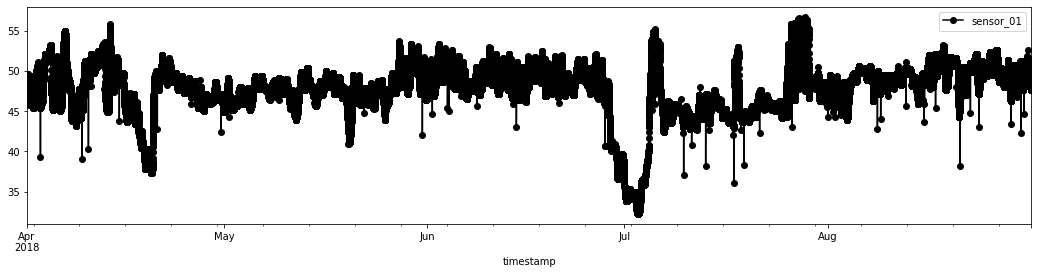

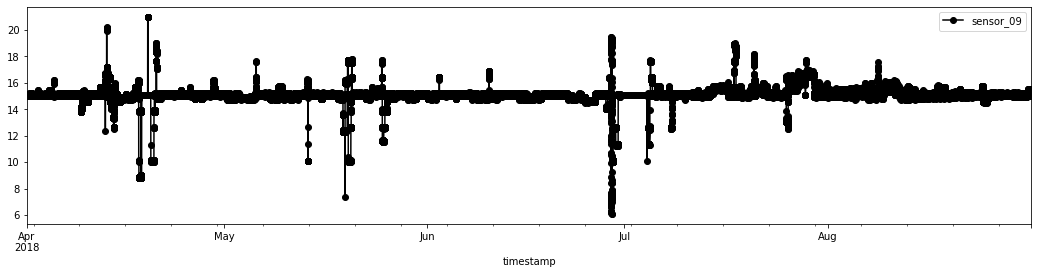

In [13]:
# Check the results of cleaning
cleaned_sensors = ['sensor_01', 'sensor_09']
for sen in cleaned_sensors:
    df_set[[sen]].plot(figsize = (18, 4), color = 'black', marker = 'o')

In [14]:
df_set.columns

Index(['timestamp', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08',
       'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
       'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24',
       'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29',
       'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34',
       'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39',
       'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49',
       'machine_status'],
      dtype='object')

In [15]:
include_cols = [
    'timestamp', 
    'sensor_00',
    'sensor_01',
    'sensor_02',
    'sensor_03',
    'sensor_04',
    'sensor_05',
    'sensor_06',
    'machine_status'
]

In [16]:
# Subset data tagged as 'Normal' operating 
df_norm = df_set.loc[df_set['machine_status'] == 'NORMAL', include_cols]  
df_norm['timestamp'] = pd.to_datetime(df_norm.index, format = '%Y-%m-%d %H:%M:%S')

# Subset data tagged as 'Normal' operating 
df_reco = df_set.loc[df_set['machine_status'] == 'RECOVERING', include_cols] 
df_reco['timestamp'] = pd.to_datetime(df_reco.index, format = '%Y-%m-%d %H:%M:%S')

# Subset data tagged as 'Normal' operating 
df_brok = df_set.loc[df_set['machine_status'] == 'BROKEN', include_cols] 
df_brok['timestamp'] = pd.to_datetime(df_brok.index, format = '%Y-%m-%d %H:%M:%S')

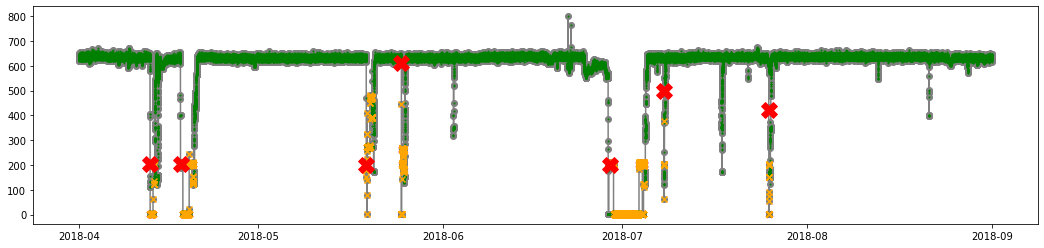

In [17]:
# Visualize machine status over time for the data using sensor04 as reference
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_set['timestamp'], df_set['sensor_04'], color = 'grey', marker = 'o', zorder = 1)
ax.scatter(df_norm['timestamp'], df_norm['sensor_04'], color ='green', marker = 'o', zorder = 2, s = 1)
ax.scatter(df_reco['timestamp'], df_reco['sensor_04'], color ='orange', marker = 'x', zorder = 3)
ax.scatter(df_brok['timestamp'], df_brok['sensor_04'], color ='red', marker = 'X', zorder = 3, s = 250)
plt.show()

Time series shows 7x recorded failures with recovery periods.  

In [18]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from matplotlib import gridspec
from matplotlib.pyplot import figure
from itertools import groupby

In [19]:
# Scale the data (between 0 and 1)
df_num = df_set.drop(['timestamp', 'machine_status'], axis = 1)
scaler = preprocessing.MinMaxScaler()
df_set_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns = df_num.columns, index = df_num.index)
df_set_scaled['timestamp'] = df_set['timestamp']
df_set_scaled['machine_status'] = df_set['machine_status']
df_set_scaled.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49
count,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,...,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000
mean,0.894917,0.627723,0.774151,0.730507,0.737412,0.733950,0.478444,0.656802,0.610348,0.602086,...,0.092794,0.036376,0.037825,0.050506,0.017351,0.057022,0.063036,0.062032,0.232684,0.069667
std,0.229663,0.134402,0.160332,0.145899,0.180685,0.173011,0.063111,0.133608,0.121586,0.048387,...,0.043674,0.019772,0.029138,0.028752,0.011882,0.043666,0.045462,0.037788,0.153641,0.043728
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.949054,0.575221,0.753320,0.675392,0.782515,0.699763,0.454140,0.671980,0.621654,0.603005,...,0.070250,0.029335,0.030325,0.039322,0.011286,0.035433,0.041211,0.042932,0.107568,0.048249
50%,0.963335,0.649558,0.808349,0.759162,0.790064,0.755765,0.469279,0.685162,0.634146,0.604945,...,0.087813,0.035202,0.036982,0.048136,0.015147,0.047244,0.053827,0.054450,0.208649,0.059484
75%,0.980702,0.704425,0.857685,0.824607,0.796307,0.809119,0.525378,0.696199,0.644259,0.607368,...,0.111229,0.042373,0.042160,0.057627,0.019899,0.062992,0.072330,0.070157,0.340000,0.077991
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
# Remove periods when pump was broken or covering + transition window
trans_win = 1*24*60

# Create map to reduce categories to two
# We want to remove 'recovering' so combine it with 'broken'
condition_map = {
    'RECOVERING': 'BROKEN', 
    'NORMAL': 'NORMAL', 
    'BROKEN': 'BROKEN'
}

In [21]:
# Use besploke function from pdm_functions
df_norm, df_abnorm = pdm.remove_segements(
    segment_vec = df_set_scaled['machine_status'],
    mapping = condition_map,
    dat = df_set_scaled,
    trans_window = trans_win,
    keep = 'NORMAL'
)

Input segement categories:  ['NORMAL' 'BROKEN' 'RECOVERING']
Categories after mapping:  ['NORMAL' 'BROKEN']
Run length encoding:  [('NORMAL', 17155), ('BROKEN', 945), ('NORMAL', 6410), ('BROKEN', 3111), ('NORMAL', 41697), ('BROKEN', 1313), ('NORMAL', 7159), ('BROKEN', 606), ('NORMAL', 49644), ('BROKEN', 8391), ('NORMAL', 4700), ('BROKEN', 42), ('NORMAL', 25267), ('BROKEN', 76), ('NORMAL', 53804)]
>
Skipping NORMAL segment(s)...
>
Remove rows:  [15715, 19539]
Removing 3825 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [23070, 29060]
Removing 5991 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [67878, 72070]
Removing 4193 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [76350, 79835]
Removing 3486 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [126600, 137870]
Removing 11271 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [139691, 142612]
Removing 2922 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [165000, 167955]
Removing 2956 rows..

In [22]:
# Quick check to confirm only one category 'normal' remains in the data
print('Remaining category:', df_norm['machine_status'].unique())
print('Remaining columns:', df_norm.columns)

Remaining category: ['NORMAL']
Remaining columns: Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'timestamp',
       'machine_status'],
      dtype='object')


In [23]:
# Check row counts
tot_rows = len(df_norm) + len(df_abnorm)
print('Nrows normal: ' + str(len(df_norm)) + ' (' + str(round(100*len(df_norm)/tot_rows)) + '%)')
print('Nrows abnorm: ' + str(len(df_abnorm)) + ' (' + str(round(100*len(df_abnorm)/tot_rows)) + '%)')

Nrows normal: 185676 (84%)
Nrows abnorm: 34644 (16%)


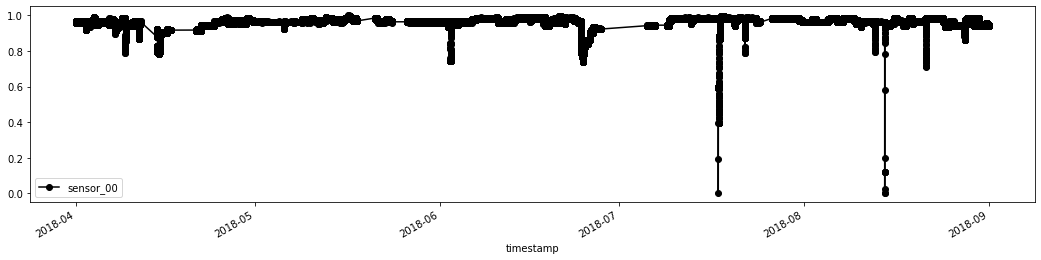

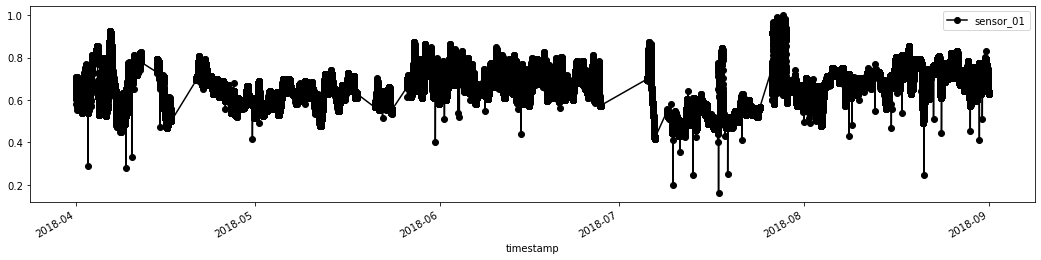

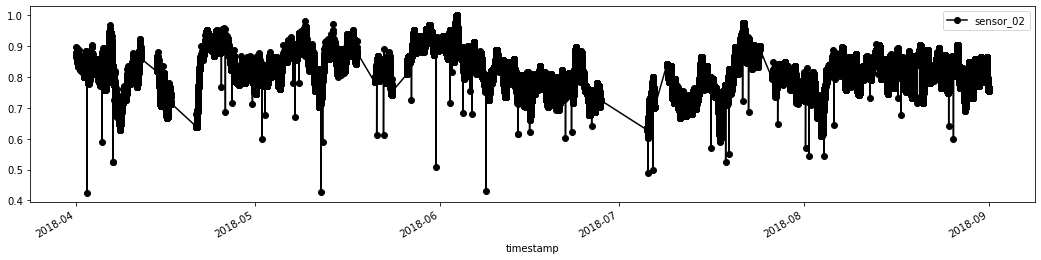

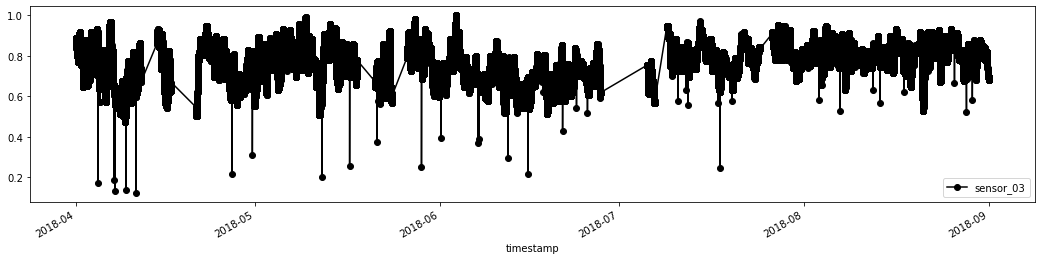

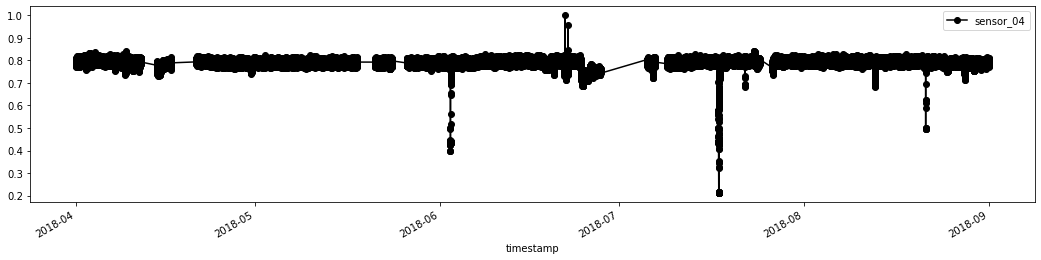

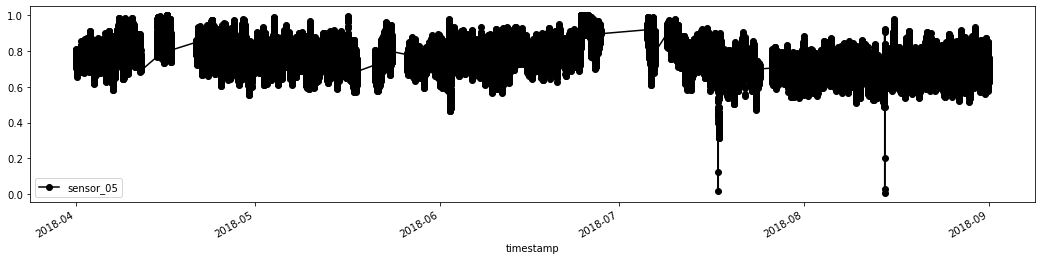

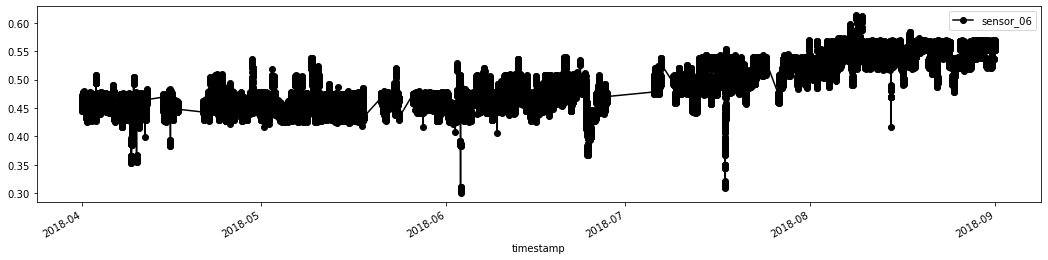

In [24]:
# Check the results of row removal
df_norm = df_norm.loc[:,include_cols] 
for sen in df_norm.columns[1:-1]:
    df_norm[[sen]].plot(figsize = (18, 4), color = 'black', marker = 'o')

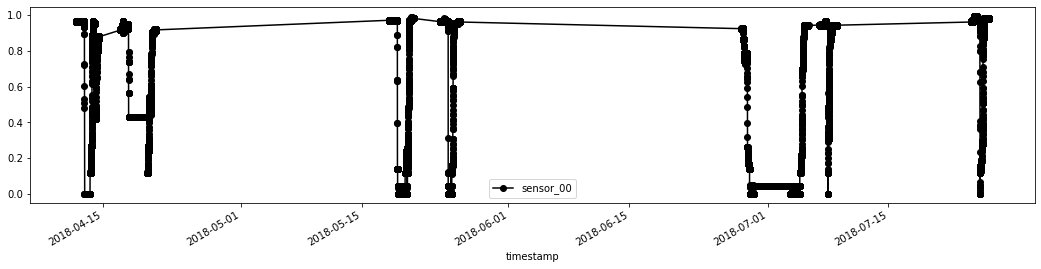

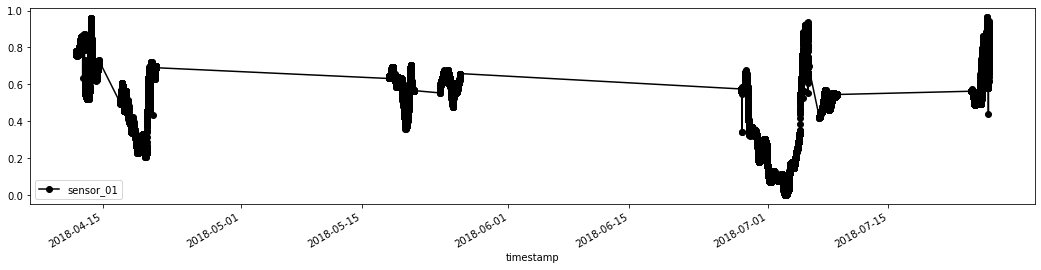

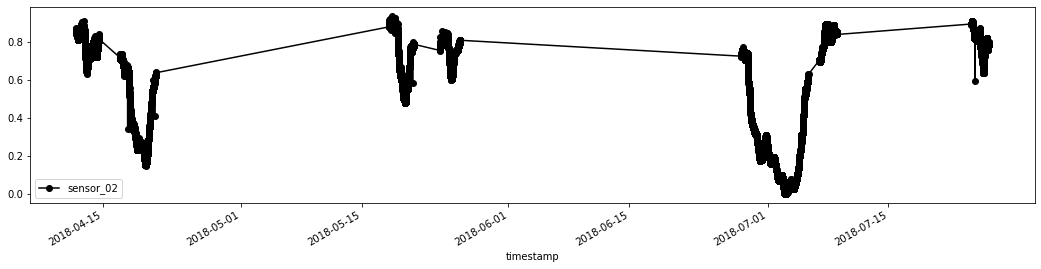

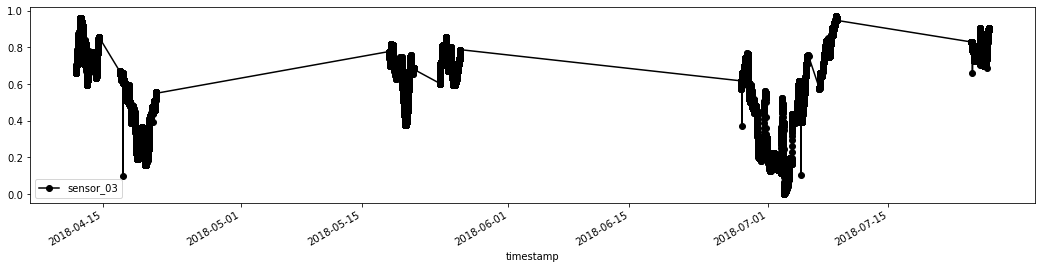

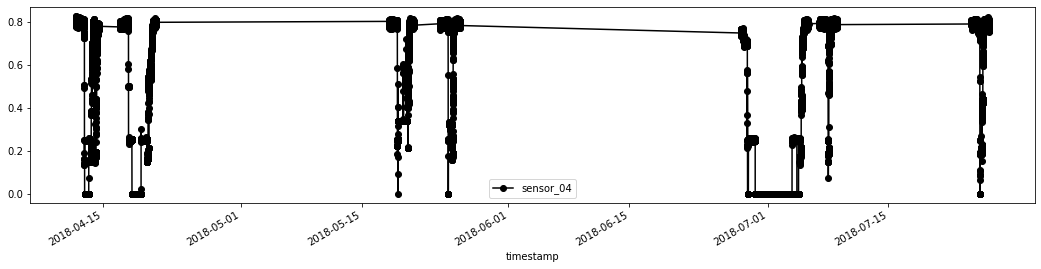

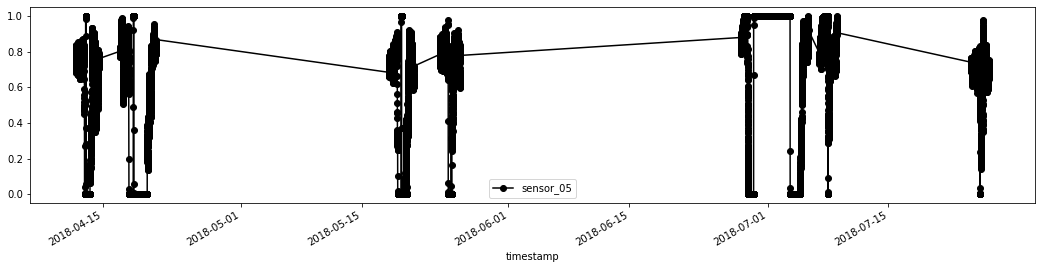

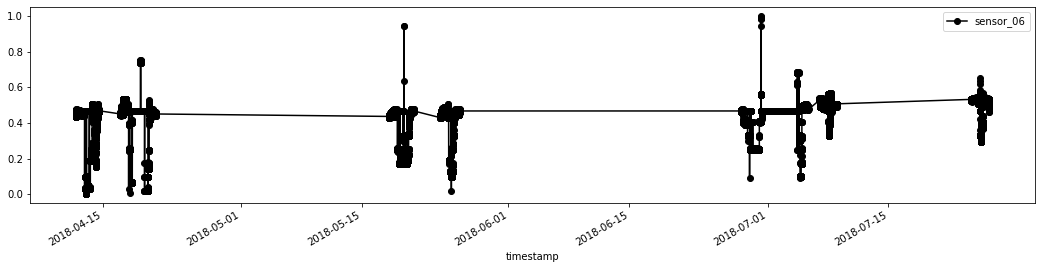

In [25]:
# Check the results of row removal
df_abnorm = df_abnorm.loc[:,include_cols] 
for sen in df_abnorm.columns[1:-1]:
    df_abnorm[[sen]].plot(figsize = (18, 4), color = 'black', marker = 'o')

In [26]:
# Create a timestamp column
df_norm['timestamp'] = pd.to_datetime(df_norm.index, format = '%Y-%m-%d %H:%M:%S')
df_abnorm['timestamp'] = pd.to_datetime(df_abnorm.index, format = '%Y-%m-%d %H:%M:%S')

In [27]:
# Split abnormal now into its different categories
df_abnorm_lead = df_abnorm.loc[df_abnorm['machine_status'] == 'NORMAL', include_cols] 
print('Test dataset 1', df_abnorm_lead['machine_status'].unique())
df_abnorm_broke = df_abnorm.loc[df_abnorm['machine_status'] == 'BROKEN', include_cols] 
print('Test dataset 2', df_abnorm_broke['machine_status'].unique())
df_abnorm_recover = df_abnorm.loc[df_abnorm['machine_status'] == 'RECOVERING', include_cols] 
print('Test dataset 3', df_abnorm_recover['machine_status'].unique())

Test dataset 1 ['NORMAL']
Test dataset 2 ['BROKEN']
Test dataset 3 ['RECOVERING']


In [28]:
# Prepare data for PCA
df_train = df_norm.loc[:, include_cols]  
df_train = df_train.drop(['machine_status', 'timestamp'], axis = 1)                      

df_test1 = df_abnorm_lead.loc[:, include_cols]
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1)  

In [29]:
print(df_train.columns)

Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06'],
      dtype='object')


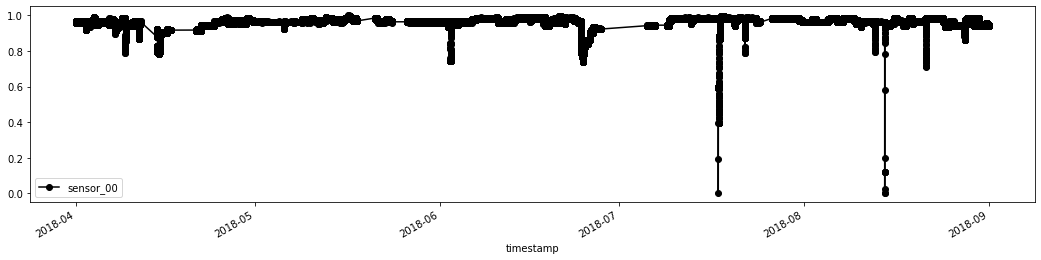

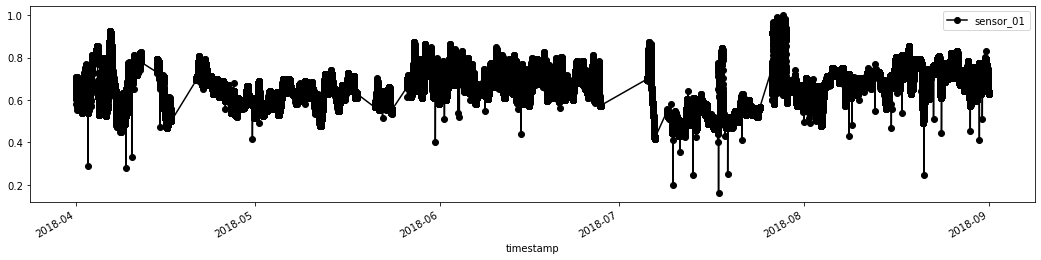

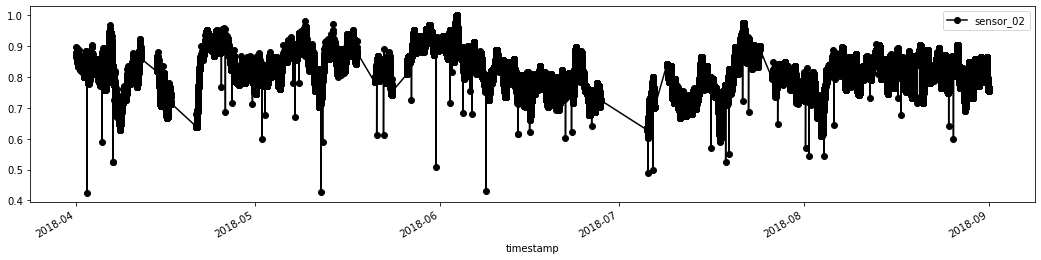

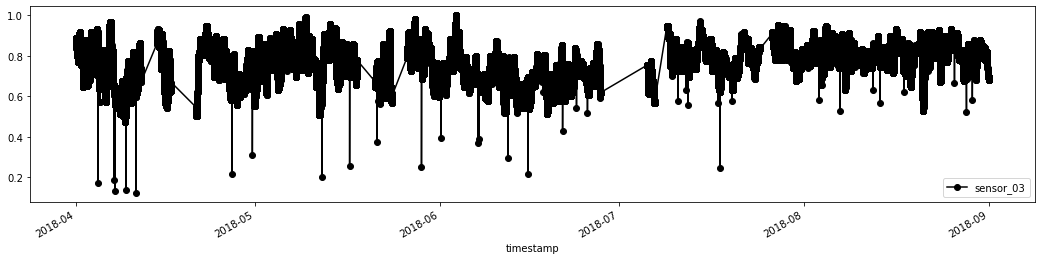

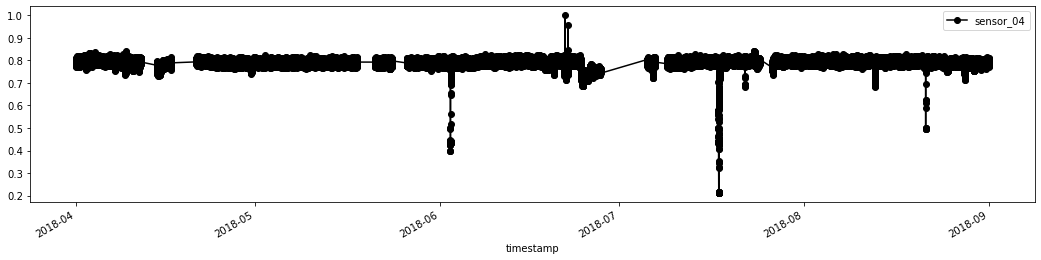

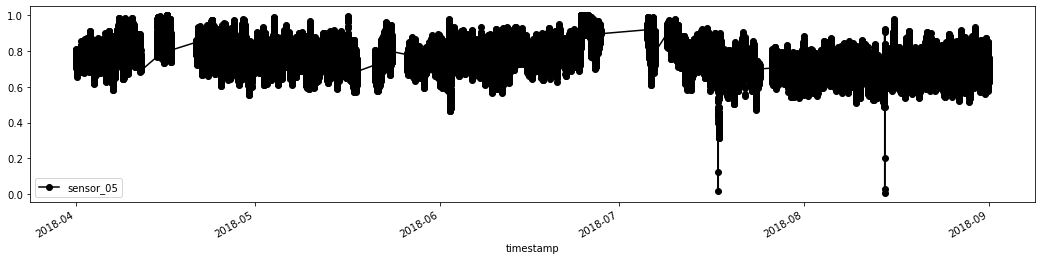

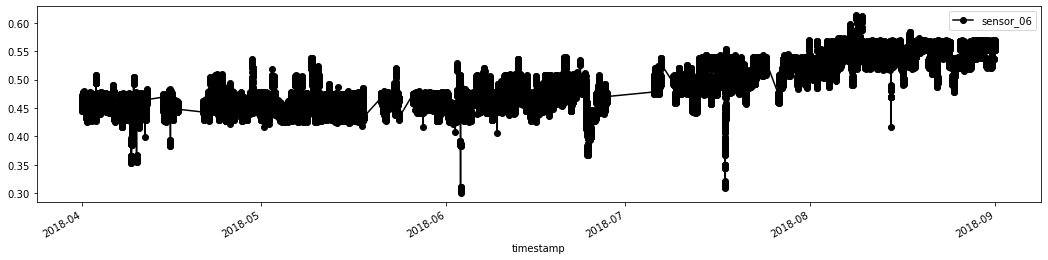

In [30]:
# Check the results of row removal
for sen in df_train.columns:
    df_train[[sen]].plot(figsize = (18, 4), color = 'black', marker = 'o')

In [31]:
# Define the PCA model (all compoments)
n_comps = 2 # How many dimensions you want to reduce to
pca = PCA(n_components = n_comps, svd_solver = 'full')

# Compute PCA components for the training set
X_train_PCA = pca.fit_transform(df_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = df_train.index

# Project the test data onto the PCA space
X_test1_PCA = pca.transform(df_test1)
X_test1_PCA = pd.DataFrame(X_test1_PCA)
X_test1_PCA.index = df_test1.index

# Project the test data onto the PCA space
X_test2_PCA = pca.transform(df_test2)
X_test2_PCA = pd.DataFrame(X_test2_PCA)
X_test2_PCA.index = df_test2.index

# Project the test data onto the PCA space
X_test3_PCA = pca.transform(df_test3)
X_test3_PCA = pd.DataFrame(X_test3_PCA)
X_test3_PCA.index = df_test3.index

# Print the explained variance
# 3 decimal places and don't use scientific notation
np.set_printoptions(precision = 3, suppress=True) 
print('Explained variance:', pca.explained_variance_ratio_)

Explained variance: [0.437 0.213]


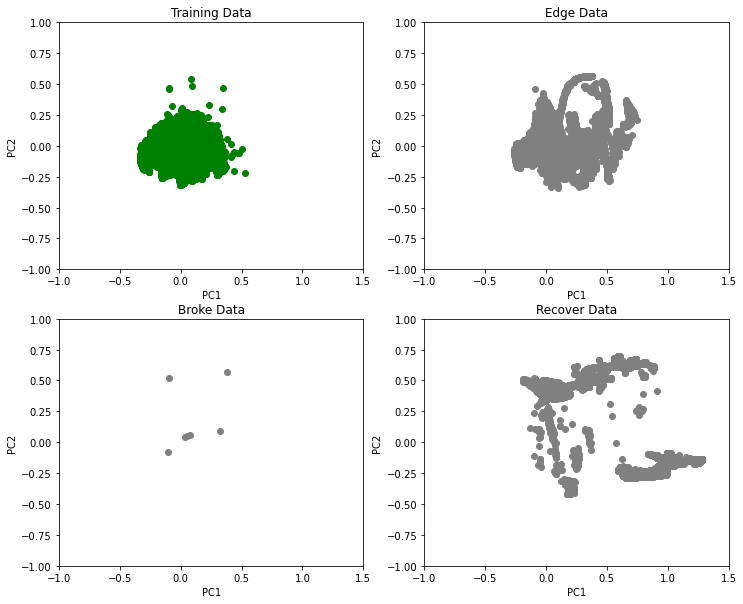

In [32]:
# Plot PC1 vs PC2 for training & test sets
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
gs = gridspec.GridSpec(2, 2, width_ratios = [1, 1])

ax0 = plt.subplot(gs[0])
ax0.scatter(X_train_PCA.loc[:, 0], X_train_PCA.loc[:, 1], color = 'green')
ax0.set_xlabel('PC1')
ax0.set_ylabel('PC2')
ax0.set_xlim(-1, 1.5)
ax0.set_ylim(-1, 1)
ax0.set_title('Training Data')

ax1 = plt.subplot(gs[1])
ax1.scatter(X_test1_PCA.loc[:, 0], X_test1_PCA.loc[:, 1], color = 'grey')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_xlim(-1, 1.5)
ax1.set_ylim(-1, 1)
ax1.set_title('Edge Data')

ax2 = plt.subplot(gs[2])
ax2.scatter(X_test2_PCA.loc[:, 0], X_test2_PCA.loc[:, 1], color = 'grey')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_xlim(-1, 1.5)
ax2.set_ylim(-1, 1)
ax2.set_title('Broke Data')

ax3 = plt.subplot(gs[3])
ax3.scatter(X_test3_PCA.loc[:, 0], X_test3_PCA.loc[:, 1], color = 'grey')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_xlim(-1, 1.5)
ax3.set_ylim(-1, 1)
ax3.set_title('Recover Data')

plt.show()

In [33]:
# Move on to calculate Mahalanobis Distance 
# This is a multivatiate distance from centroid calculation that
# can be useful for unsupervised anomaly detection
data_train = np.array(X_train_PCA.values)
data_test1 = np.array(X_test1_PCA.values)
data_test2 = np.array(X_test2_PCA.values)
data_test3 = np.array(X_test3_PCA.values)

cov_matrix = np.cov(data_train, rowvar = False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Mean of each column: PC1, PC2 (it should be very close to zero)
mean_distr = data_train.mean(axis = 0) # axis=0 means that average is computed per column
np.set_printoptions(precision = 3, suppress = False)
print('Mean distr', mean_distr)

# Mahalanobis Distance calculation
dist_test1 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test1, verbose=False)
dist_test2 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test2, verbose=False)
dist_test3 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test3, verbose=False)
dist_train = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)

print("Minimum & maximum MD in training set:", min(dist_train), max(dist_train))
print("Minimum & maximum MD in test set 1  :", min(dist_test1), max(dist_test1))
print("Minimum & maximum MD in test set 2  :", min(dist_test2), max(dist_test2))
print("Minimum & maximum MD in test set 3  :", min(dist_test3), max(dist_test3))

threshold = pdm.MD_threshold(dist_train, extreme = True) # extreme = True; 2x mean of incoming data
print("Threshold value for flagging an anomaly is", "{:.2f}".format(threshold))

Mean distr [5.909e-17 5.909e-17]
Minimum & maximum MD in training set: 0.004675794439548307 6.913924174552735
Minimum & maximum MD in test set 1  : 0.0017588812406509268 7.9318717479533145
Minimum & maximum MD in test set 2  : 0.6508776639792797 7.928952850525483
Minimum & maximum MD in test set 3  : 0.5789546985026571 11.545358797487486
Threshold value for flagging an anomaly is 3.77


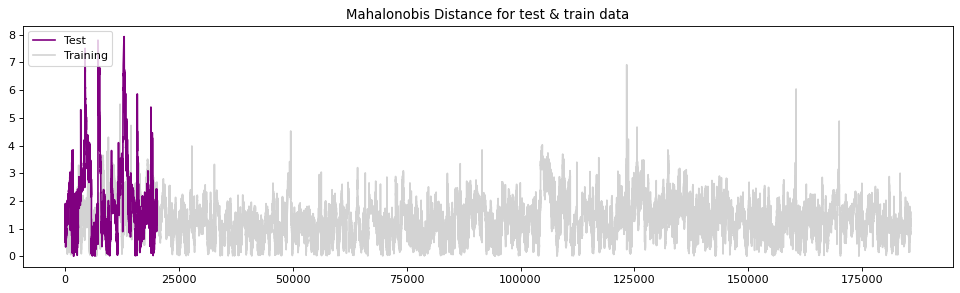

In [34]:
figure(figsize = (15, 4), dpi = 80)
plt.plot(np.array(dist_test1), label = "Test", color = 'purple', zorder = 2)
plt.plot(np.array(dist_train) , label = "Training", color = 'lightgrey', zorder = 1)
plt.legend(loc = "upper left")
plt.title("Mahalonobis Distance for test & train data")
plt.show()

/Users/jasonpayne/opt/anaconda3/envs/pdm/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


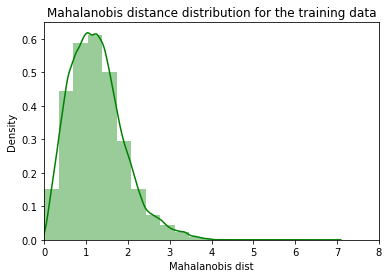

In [35]:
import seaborn as sns
plt.figure()
sns.distplot(dist_train,
             bins = 20, 
             kde = True, 
            color = 'green');
plt.xlim([0.0, 8])
plt.xlabel('Mahalanobis dist')
plt.title('Mahalanobis distance distribution for the training data')
plt.show()

In [36]:
def prep_mahalonobis_data (dist_dat, thresh, pca_dat):
    # Prepare test data for visualization
    dat = pd.DataFrame()
    dat['Mob dist'] = dist_dat
    dat['Thresh'] = thresh
    dat['Anomaly'] = dat['Mob dist'] > dat['Thresh']
    dat.index = pca_dat.index
    dat['timestamp'] = dat.index

    n_outliers = dat[dat['Anomaly'] == True].shape[0]
    print("There are", n_outliers, "anomalies in the test set out of", dat.shape[0], "points")
    print("Corresponding to " + str(round(100*(n_outliers / dat.shape[0]), 2)) + '%')

    return(dat)

In [37]:
# Prepare training data for visualization
# If Mahalonobis distance is above threshold: Flag as anomaly
anomaly_train = pdm.prep_mahalonobis_data(dist_train, threshold, X_train_PCA)
anomaly1 = pdm.prep_mahalonobis_data(dist_test1, threshold, X_test1_PCA)
anomaly2 = pdm.prep_mahalonobis_data(dist_test2, threshold, X_test2_PCA)
anomaly3 = pdm.prep_mahalonobis_data(dist_test3, threshold, X_test3_PCA)

There are 166 anomalies in the test set out of 185676 points
> Corresponding to 0.09%
There are 1864 anomalies in the test set out of 20160 points
> Corresponding to 9.25%
There are 2 anomalies in the test set out of 7 points
> Corresponding to 28.57%
There are 14251 anomalies in the test set out of 14477 points
> Corresponding to 98.44%


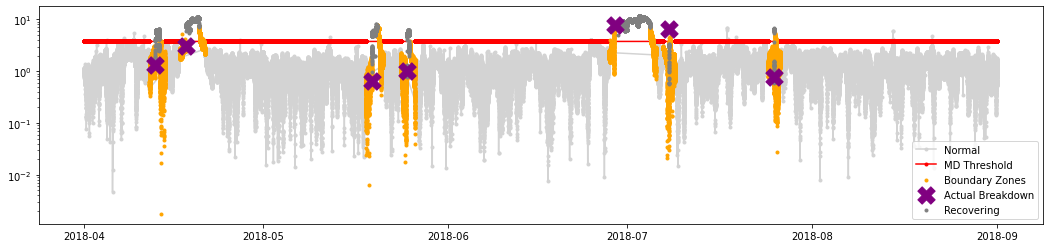

In [38]:
# Visualize Mahalonobis distance with actual anomalies vs threshold  
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(anomaly_train['timestamp'], anomaly_train['Mob dist'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Normal')
ax.plot(anomaly_train['timestamp'], anomaly_train['Thresh'], color = 'red', marker = '.', zorder = 2, label = 'MD Threshold')
ax.scatter(anomaly1['timestamp'], anomaly1['Mob dist'], color = 'orange', marker = '.', zorder = 3, label = 'Boundary Zones')
ax.scatter(anomaly2['timestamp'], anomaly2['Mob dist'], color = 'purple', marker = 'X', zorder = 5, s = 300, label = 'Actual Breakdown')
ax.scatter(anomaly3['timestamp'], anomaly3['Mob dist'], color = 'grey', marker = '.', zorder = 4, label = 'Recovering')
ax.set_yscale('log')
ax.legend(loc = 'lower right')
plt.show()

### Robust PCA

In [39]:
# Prepare data for PCA
df_train = df_norm.loc[:, include_cols]  
df_train = df_train.drop(['machine_status', 'timestamp'], axis = 1)                      

df_test1 = df_abnorm_lead.loc[:, include_cols]
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1)

# Compute all PCA components for the training set
L_train, S_train = pdm.R_pca(df_train).fit()
X_train_PCA = pca.fit_transform(L_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = df_train.index

# Project the test data onto the PCA space
L_test1, S_test1 = pdm.R_pca(df_test1).fit()
X_test1_PCA = pca.transform(L_test1)
X_test1_PCA = pd.DataFrame(X_test1_PCA)
X_test1_PCA.index = df_test1.index

L_test2, S_test2 = pdm.R_pca(df_test2).fit()
X_test2_PCA = pca.transform(L_test2)
X_test2_PCA = pd.DataFrame(X_test2_PCA)
X_test2_PCA.index = df_test2.index

L_test3, S_test3 = pdm.R_pca(df_test3).fit()
X_test3_PCA = pca.transform(L_test3)
X_test3_PCA = pd.DataFrame(X_test3_PCA)
X_test3_PCA.index = df_test3.index

iteration: 1, error: 1.038623242451124
iteration: 100, error: 0.006959014475317882
iteration: 200, error: 0.003982448973976776
iteration: 300, error: 0.002422792389774784
iteration: 400, error: 0.0033831832445396833
iteration: 500, error: 0.001489319554496669
iteration: 600, error: 0.0011355119871216245
iteration: 700, error: 0.0008667102198825708
iteration: 800, error: 0.0005623964322153399
iteration: 900, error: 0.00031618816417210567
iteration: 1000, error: 0.0002481960790112833
iteration: 1, error: 0.8603327082057718
iteration: 100, error: 0.007507367483137707
iteration: 200, error: 0.004620205770398407
iteration: 300, error: 0.0024171769314781945
iteration: 400, error: 0.0016981514762012032
iteration: 500, error: 0.0009472845473848574
iteration: 600, error: 0.0005692926099432385
iteration: 700, error: 0.0002676193817316079
iteration: 800, error: 0.00018749104629941918
iteration: 900, error: 0.00010046159288468967
iteration: 1000, error: 5.874550227088736e-05
iteration: 1, error: 0

In [40]:
# 3 decimal places and don't use scientific notation
np.set_printoptions(precision = 3, suppress = True) 
print('Explained variance:', pca.explained_variance_ratio_)

Explained variance: [0.864 0.09 ]


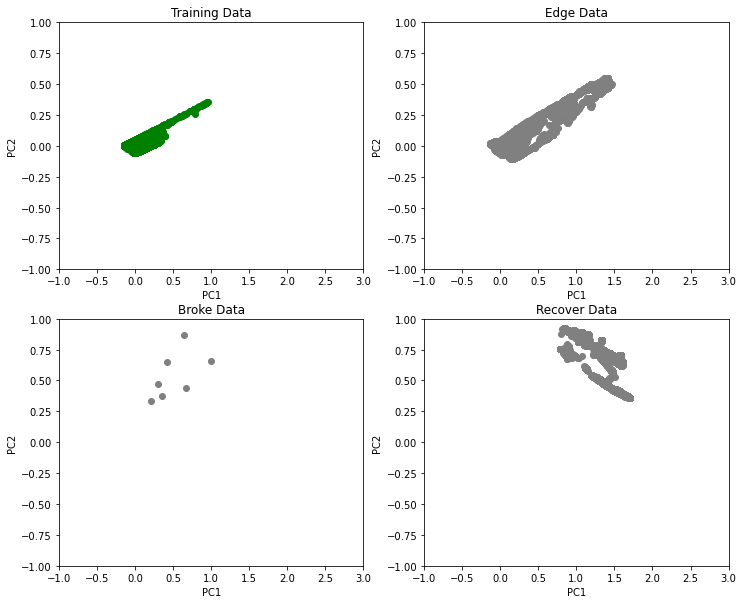

In [41]:
# Plot PC1 vs PC2 for training & test sets
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
gs = gridspec.GridSpec(2, 2, width_ratios = [1, 1])

ax0 = plt.subplot(gs[0])
ax0.scatter(X_train_PCA.loc[:, 0], X_train_PCA.loc[:, 1], color = 'green')
ax0.set_xlabel('PC1')
ax0.set_ylabel('PC2')
ax0.set_xlim(-1, 3)
ax0.set_ylim(-1, 1)
ax0.set_title('Training Data')

ax1 = plt.subplot(gs[1])
ax1.scatter(X_test1_PCA.loc[:, 0], X_test1_PCA.loc[:, 1], color = 'grey')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_xlim(-1, 3)
ax1.set_ylim(-1, 1)
ax1.set_title('Edge Data')

ax2 = plt.subplot(gs[2])
ax2.scatter(X_test2_PCA.loc[:, 0], X_test2_PCA.loc[:, 1], color = 'grey')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_xlim(-1, 3)
ax2.set_ylim(-1, 1)
ax2.set_title('Broke Data')

ax3 = plt.subplot(gs[3])
ax3.scatter(X_test3_PCA.loc[:, 0], X_test3_PCA.loc[:, 1], color = 'grey')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_xlim(-1, 3)
ax3.set_ylim(-1, 1)
ax3.set_title('Recover Data')

plt.show()

In [42]:
# Move on to calculate Mahalanobis Distance 
# This is a multivatiate distance from centroid calculation that
# can be useful for unsupervised anomaly detection
data_train = np.array(X_train_PCA.values)
data_test1 = np.array(X_test1_PCA.values)
data_test2 = np.array(X_test2_PCA.values)
data_test3 = np.array(X_test3_PCA.values)

cov_matrix = np.cov(data_train, rowvar = False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Mean of each column: PC1, PC2 (it should be very close to zero)
mean_distr = data_train.mean(axis = 0) # axis=0 means that average is computed per column
np.set_printoptions(precision = 3, suppress = False)
print('Mean distr', mean_distr)

# Mahalanobis Distance calculation
dist_test1 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test1, verbose=False)
dist_test2 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test2, verbose=False)
dist_test3 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test3, verbose=False)
dist_train = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)

print("Minimum & maximum MD in training set:", min(dist_train), max(dist_train))
print("Minimum & maximum MD in test set 1  :", min(dist_test1), max(dist_test1))
print("Minimum & maximum MD in test set 2  :", min(dist_test2), max(dist_test2))
print("Minimum & maximum MD in test set 3  :", min(dist_test3), max(dist_test3))

threshold = pdm.MD_threshold(dist_train, extreme = True) # extreme = True; 2x mean of incoming data
print("Threshold value for flagging an anomaly is", "{:.2f}".format(threshold))

Mean distr [1.638e-15 2.744e-14]
Minimum & maximum MD in training set: 0.0070003677003165465 20.420988286826844
Minimum & maximum MD in test set 1  : 0.05693282596336806 31.162622677688336
Minimum & maximum MD in test set 2  : 14.753119301172676 38.85792944637424
Minimum & maximum MD in test set 3  : 27.88258836847665 42.15637330934416
Threshold value for flagging an anomaly is 3.57


/Users/jasonpayne/opt/anaconda3/envs/pdm/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


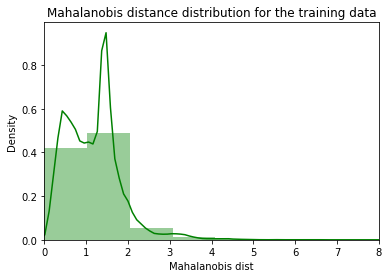

In [43]:
import seaborn as sns
plt.figure()
sns.distplot(dist_train,
             bins = 20, 
             kde= True, 
            color = 'green');
plt.xlim([0.0, 8])
plt.xlabel('Mahalanobis dist')
plt.title('Mahalanobis distance distribution for the training data')
plt.show()

In [44]:
# Prepare training data for visualization
# If Mahalonobis distance is above threshold: Flag as anomaly
anomaly_train = prep_mahalonobis_data(dist_train, threshold, X_train_PCA)
anomaly1 = prep_mahalonobis_data(dist_test1, threshold, X_test1_PCA)
anomaly2 = prep_mahalonobis_data(dist_test2, threshold, X_test2_PCA)
anomaly3 = prep_mahalonobis_data(dist_test3, threshold, X_test3_PCA)

There are 1552 anomalies in the test set out of 185676 points
Corresponding to 0.84%
There are 7125 anomalies in the test set out of 20160 points
Corresponding to 35.34%
There are 7 anomalies in the test set out of 7 points
Corresponding to 100.0%
There are 14477 anomalies in the test set out of 14477 points
Corresponding to 100.0%


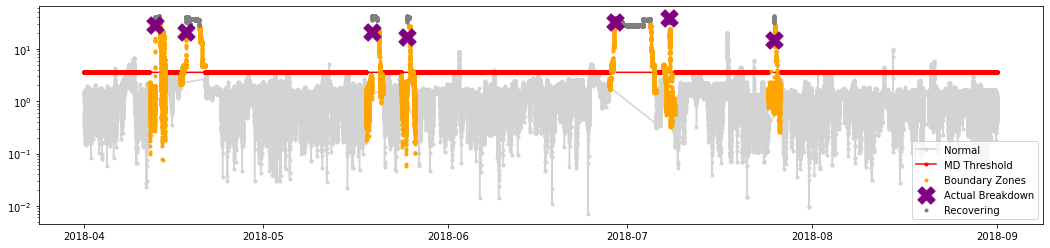

In [53]:
# Visualize Mahalonobis distance with actual anomalies vs threshold  
ZOOM = False
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(anomaly_train['timestamp'], anomaly_train['Mob dist'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Normal')
ax.plot(anomaly_train['timestamp'], anomaly_train['Thresh'], color = 'red', marker = '.', zorder = 2, label = 'MD Threshold')
ax.scatter(anomaly1['timestamp'], anomaly1['Mob dist'], color = 'orange', marker = '.', zorder = 3, label = 'Boundary Zones')
ax.scatter(anomaly2['timestamp'], anomaly2['Mob dist'], color = 'purple', marker = 'X', zorder = 5, s = 300, label = 'Actual Breakdown')
ax.scatter(anomaly3['timestamp'], anomaly3['Mob dist'], color = 'grey', marker = '.', zorder = 4, label = 'Recovering')
ax.set_yscale('log')
if ZOOM is True:
    ax.set_xlim(
        pd.to_datetime('2018-04-10 00:00:00', format = '%Y-%m-%d %H:%M:%S'), 
        pd.to_datetime('2018-04-20 00:00:00', format = '%Y-%m-%d %H:%M:%S')
    )
ax.legend(loc = 'lower right')
plt.show()

### Uniform Manifold Approximation & Projection (UMAP)
https://umap-learn.readthedocs.io/en/latest/basic_usage.html

In [54]:
import umap

In [79]:
# Prepare data for dimensional reduction
df_train = df_norm.loc[:, include_cols]  
df_train = df_train.drop(['machine_status', 'timestamp'], axis = 1)                      

df_test1 = df_abnorm_lead.loc[:, include_cols]
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1)

# Fit & transform training data using UMAP
reducer = umap.UMAP()
X_train_UMAP = reducer.fit_transform(df_train)
print('UMAP embeddings shape', X_train_UMAP.shape)

UMAP embeddings shape (185676, 2)


In [80]:
# Project test data on to the UMAP sapce
X_test1_UMAP = reducer.transform(df_test1)
X_test2_UMAP = reducer.transform(df_test2)
X_test3_UMAP = reducer.transform(df_test3)

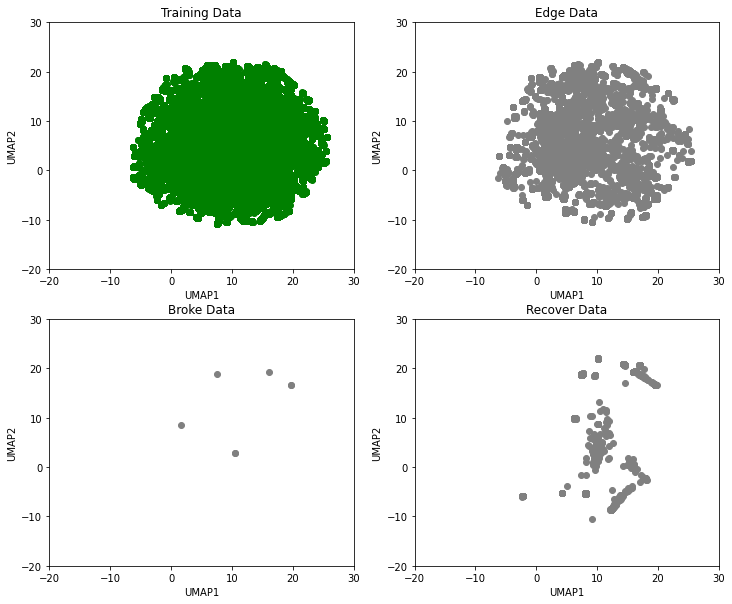

In [81]:
# Plot PC1 vs PC2 for training & test sets
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
gs = gridspec.GridSpec(2, 2, width_ratios = [1, 1])

ax0 = plt.subplot(gs[0])
ax0.scatter(X_train_UMAP[:, 0], X_train_UMAP[:, 1], color = 'green')
ax0.set_xlabel('UMAP1')
ax0.set_ylabel('UMAP2')
ax0.set_xlim(-20, 30)
ax0.set_ylim(-20, 30)
ax0.set_title('Training Data')

ax1 = plt.subplot(gs[1])
ax1.scatter(X_test1_UMAP[:, 0], X_test1_UMAP[:, 1], color = 'grey')
ax1.set_xlabel('UMAP1')
ax1.set_ylabel('UMAP2')
ax1.set_xlim(-20, 30)
ax1.set_ylim(-20, 30)
ax1.set_title('Edge Data')

ax2 = plt.subplot(gs[2])
ax2.scatter(X_test2_UMAP[:, 0], X_test2_UMAP[:, 1], color = 'grey')
ax2.set_xlabel('UMAP1')
ax2.set_ylabel('UMAP2')
ax2.set_xlim(-20, 30)
ax2.set_ylim(-20, 30)
ax2.set_title('Broke Data')

ax3 = plt.subplot(gs[3])
ax3.scatter(X_test3_UMAP[:, 0], X_test3_UMAP[:, 1], color = 'grey')
ax3.set_xlabel('UMAP1')
ax3.set_ylabel('UMAP2')
ax3.set_xlim(-20, 30)
ax3.set_ylim(-20, 30)
ax3.set_title('Recover Data')

plt.show()

In [82]:
# Move on to calculate Mahalanobis Distance 
# This is a multivatiate distance from centroid calculation that
# can be useful for unsupervised anomaly detection
data_train = np.array(X_train_UMAP)
data_test1 = np.array(X_test1_UMAP)
data_test2 = np.array(X_test2_UMAP)
data_test3 = np.array(X_test3_UMAP)

cov_matrix = np.cov(data_train, rowvar = False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Mean of each column: PC1, PC2 (it should be very close to zero)
mean_distr = data_train.mean(axis = 0) # axis=0 means that average is computed per column
np.set_printoptions(precision = 3, suppress = False)
print('Mean distr', mean_distr)

# Mahalanobis Distance calculation
dist_test1 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test1, verbose=False)
dist_test2 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test2, verbose=False)
dist_test3 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test3, verbose=False)
dist_train = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)

print("Minimum & maximum MD in training set:", min(dist_train), max(dist_train))
print("Minimum & maximum MD in test set 1  :", min(dist_test1), max(dist_test1))
print("Minimum & maximum MD in test set 2  :", min(dist_test2), max(dist_test2))
print("Minimum & maximum MD in test set 3  :", min(dist_test3), max(dist_test3))

threshold = pdm.MD_threshold(dist_train, extreme = True) # extreme = True; 2x mean of incoming data
print("Threshold value for flagging an anomaly is", "{:.2f}".format(threshold))

Mean distr [9.587 5.326]
Minimum & maximum MD in training set: 0.030168963526700704 2.492068859488774
Minimum & maximum MD in test set 1  : 0.09025447005391087 2.4880114004983573
Minimum & maximum MD in test set 2  : 0.3728775981124904 2.1703459806712484
Minimum & maximum MD in test set 3  : 0.06408424760246875 2.3939391132774386
Threshold value for flagging an anomaly is 3.93


/Users/jasonpayne/opt/anaconda3/envs/pdm/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


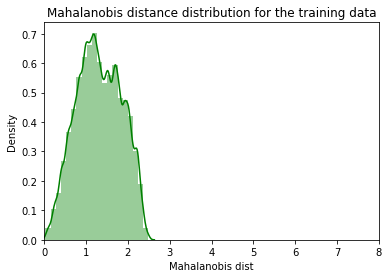

In [83]:
import seaborn as sns
plt.figure()
sns.distplot(dist_train,
             bins = 20, 
             kde= True, 
            color = 'green');
plt.xlim([0.0, 8])
plt.xlabel('Mahalanobis dist')
plt.title('Mahalanobis distance distribution for the training data')
plt.show()

In [84]:
# Prepare training data for visualization
# If Mahalonobis distance is above threshold: Flag as anomaly
anomaly_train = prep_mahalonobis_data(dist_train, threshold, X_train_PCA)
anomaly1 = prep_mahalonobis_data(dist_test1, threshold, X_test1_PCA)
anomaly2 = prep_mahalonobis_data(dist_test2, threshold, X_test2_PCA)
anomaly3 = prep_mahalonobis_data(dist_test3, threshold, X_test3_PCA)

There are 0 anomalies in the test set out of 185676 points
Corresponding to 0.0%
There are 0 anomalies in the test set out of 20160 points
Corresponding to 0.0%
There are 0 anomalies in the test set out of 7 points
Corresponding to 0.0%
There are 0 anomalies in the test set out of 14477 points
Corresponding to 0.0%


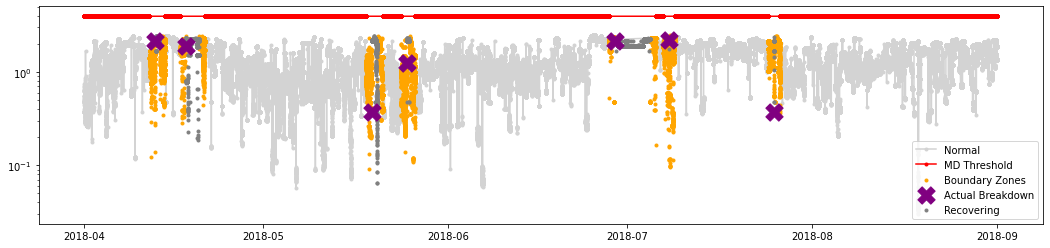

In [85]:
# Visualize Mahalonobis distance with actual anomalies vs threshold  
ZOOM = False
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(anomaly_train['timestamp'], anomaly_train['Mob dist'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Normal')
ax.plot(anomaly_train['timestamp'], anomaly_train['Thresh'], color = 'red', marker = '.', zorder = 2, label = 'MD Threshold')
ax.scatter(anomaly1['timestamp'], anomaly1['Mob dist'], color = 'orange', marker = '.', zorder = 3, label = 'Boundary Zones')
ax.scatter(anomaly2['timestamp'], anomaly2['Mob dist'], color = 'purple', marker = 'X', zorder = 5, s = 300, label = 'Actual Breakdown')
ax.scatter(anomaly3['timestamp'], anomaly3['Mob dist'], color = 'grey', marker = '.', zorder = 4, label = 'Recovering')
ax.set_yscale('log')
if ZOOM is True:
    ax.set_xlim(
        pd.to_datetime('2018-04-10 00:00:00', format = '%Y-%m-%d %H:%M:%S'), 
        pd.to_datetime('2018-04-20 00:00:00', format = '%Y-%m-%d %H:%M:%S')
    )
ax.legend(loc = 'lower right')
plt.show()

### One-class Support Vector Machine (SVM)

In [88]:
from sklearn.svm import OneClassSVM

In [89]:
# Prepare data for dimensional reduction
df_train = df_norm.loc[:, include_cols]  
df_train = df_train.drop(['machine_status', 'timestamp'], axis = 1)                      

df_test1 = df_abnorm_lead.loc[:, include_cols]
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1)

In [90]:
# An estimation of anomaly population of the dataset
outliers_fraction = 0.1

# Train a one-class SVM 
svm_model =  OneClassSVM(nu = 0.95 * outliers_fraction) 
svm_model.fit(pd.DataFrame(df_train))

OneClassSVM(nu=0.095)

In [114]:
# Predict for train set (normal operating)
preds = pd.Series(svm_model.predict(df_train))
test = pd.DataFrame({'sensor_04':pd.Series(df_train['sensor_04'])})
svm_out = pd.DataFrame({'timestamp':df_train.index, 'Prediction':preds})
sensor_04 = df_train['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
svm_out['sensor_04'] = sensor_04
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly0 = svm_aly

17638 out of 185676 (9.5%)


In [107]:
# Predict for test set 1 (boundary segments)
preds = pd.Series(svm_model.predict(df_test1))
test = pd.DataFrame({'sensor_04':pd.Series(df_test1['sensor_04'])})
svm_out = pd.DataFrame({'timestamp':df_test1.index, 'Prediction':preds})
sensor_04 = df_test1['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
svm_out['sensor_04'] = sensor_04
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly1 = svm_aly

9088 out of 20160 (45.08%)


In [104]:
# Predict for test set 2 (breakdown points)
preds = pd.Series(svm_model.predict(df_test2))
test = pd.DataFrame({'sensor_04':pd.Series(df_test2['sensor_04'])})
svm_out = pd.DataFrame({'timestamp':df_test2.index, 'Prediction':preds})
sensor_04 = df_test2['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
svm_out['sensor_04'] = sensor_04
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly2 = svm_aly

6 out of 7 (85.71%)


In [106]:
# Predict for test set 3 (recovery points)
preds = pd.Series(svm_model.predict(df_test3))
test = pd.DataFrame({'sensor_04':pd.Series(df_test3['sensor_04'])})
svm_out = pd.DataFrame({'timestamp':df_test3.index, 'Prediction':preds})
sensor_04 = df_test3['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
svm_out['sensor_04'] = sensor_04
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly3 = svm_aly

14477 out of 14477 (100.0%)


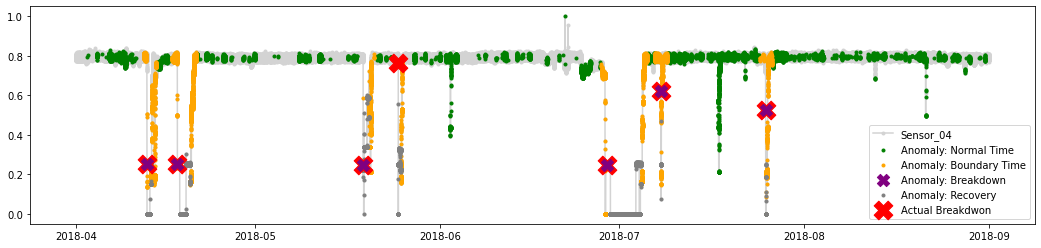

In [115]:
# Visualize machine status over time for the data using sensor04 as reference
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_set['timestamp'], df_set_scaled['sensor_04'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Sensor_04')
ax.scatter(svm_aly0['timestamp'], svm_aly0['sensor_04'], color ='green', marker = '.', zorder = 2, label = 'Anomaly: Normal Time')
ax.scatter(svm_aly1['timestamp'], svm_aly1['sensor_04'], color ='orange', marker = '.', zorder = 2, label = 'Anomaly: Boundary Time')
ax.scatter(svm_aly2['timestamp'], svm_aly2['sensor_04'], color ='purple', marker = 'X', s = 150, zorder = 5, label = 'Anomaly: Breakdown')
ax.scatter(svm_aly3['timestamp'], svm_aly3['sensor_04'], color ='grey', marker = '.', zorder = 3, label = 'Anomaly: Recovery')
ax.scatter(df_abnorm_broke['timestamp'], df_abnorm_broke['sensor_04'], color = 'red', marker = 'X', zorder = 4, s = 350, label = 'Actual Breakdwon')
ax.legend(loc = 'lower right')
plt.show()